In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow version: 1.7.0
Eager execution: True


In [2]:
# 우리가 피팅시킬 변수들:
true_w = 3
true_b = 2

NUM_EXAMPLES = 1000

# 입력:
inputs = tf.random_normal(shape=[NUM_EXAMPLES, 1])

# 노이즈를 포함한 레이블 :
noise = tf.random_normal(shape=[NUM_EXAMPLES, 1])
labels = inputs * true_w + true_b + noise

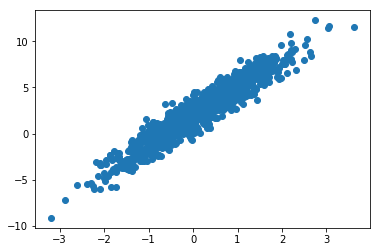

In [3]:
# 데이터 시각화 (Optional)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(inputs.numpy(), labels.numpy())
plt.show()

In [4]:
# Keras의 Dense layer를 이용하여 TensorFlow 변수 생성

wb = tf.layers.Dense(units=1, use_bias=True)

# wb.variables를 통해서 TensorFlow 변수 내부에 접근 가능합니다.
# 하지만 변수는 입력 Tensor를 알기전까진 존재하지 않습니다.
# 입력 텐서의 차원이 한번 정해지고 나먼, keras는 변수를 생성하고 초기화 합니다. 
# 그 전까진 Keras는 변수를 빈 리스트: []로 보고합니다.

wb.variables

[]

In [5]:
def loss_fn(inputs, labels, wb):
  """선형 모델의 L2 loss를 계산힙니다."""
  predictions = wb(inputs)
  return tf.reduce_mean(tf.square(predictions - labels))

In [6]:
# 손실 함수 평가하기 (optional).

loss_fn(inputs, labels, wb)

<tf.Tensor: id=49, shape=(), dtype=float32, numpy=27.818464>

In [7]:
# 이때, 변수가 존재하게 되며, 질의에 대한 처리를 할 수 있습니다:

w, b = wb.variables
print("w: " + str(w.read_value()))
print("b: " + str(b.read_value()))

w: tf.Tensor([[-1.6239487]], shape=(1, 1), dtype=float32)
b: tf.Tensor([0.], shape=(1,), dtype=float32)


In [8]:
# 경사 함수를 만듭니다. 
# 반환되는 함수의 형태에 대한 설명을 참고하시기 바랍니다. 

value_and_gradients_fn = tfe.implicit_value_and_gradients(loss_fn)

In [9]:
# value_and_gradients_fn의 출력을 확인합니다.

print("Outputs of value_and_gradients_fn:")

value, grads_and_vars = value_and_gradients_fn(inputs, labels, wb)

print('Loss: {}'.format(value))
for (grad, var) in grads_and_vars:
  print("")
  print('Gradient: {}\nVariable: {}'.format(grad, var))

Outputs of value_and_gradients_fn:
Loss: 27.818464279174805

Gradient: [[-9.616679]]
Variable: <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.6239487]], dtype=float32)>

Gradient: [-4.510632]
Variable: <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


In [10]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

In [11]:
# optimizer를 평가합니다.

print("Values of w, b, BEFORE applying gradients:")
w, b = wb.variables
print(w.read_value().numpy(), b.read_value().numpy())
print()

# 경사를 계산합니다:
empirical_loss, gradients_and_variables = value_and_gradients_fn(
    inputs, labels, wb)
optimizer.apply_gradients(gradients_and_variables)

print("Values of w, b, AFTER applying gradients:")
print(w.read_value().numpy(), b.read_value().numpy())

Values of w, b, BEFORE applying gradients:
[[-1.6239487]] [0.]

Values of w, b, AFTER applying gradients:
[[-0.66228074]] [0.45106322]


[0.10077929496765137, 0.7063601016998291, 1.1870520114898682, 1.56868314743042, 1.871726155281067, 2.1124112606048584, 2.303607702255249, 2.455521583557129, 2.5762484073638916, 2.672210216522217]


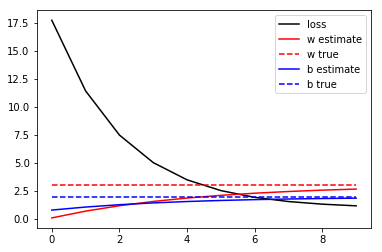

In [12]:
# 변수를 학습시킵니다.

# numpy 는 asscalar() 함수를 위해 사용됩니다.
import numpy as np

num_training_steps = 10

def train_model(inputs, labels, wb, optimizer, num_training_steps):
  loss_at_step = []
  w_at_step = []
  b_at_step = []
  for step_num in range(num_training_steps):
    loss, gradients_and_variables = value_and_gradients_fn(inputs, labels, wb)
    loss_at_step.append(np.asscalar(loss.numpy()))
    
    optimizer.apply_gradients(gradients_and_variables)
    w, b = wb.variables
    w_at_step.append(np.asscalar(w.read_value().numpy()))
    b_at_step.append(np.asscalar(b.read_value().numpy()))

  print(w_at_step)
  t = range(0, num_training_steps)
  plt.plot(t, loss_at_step, 'k',
           t, w_at_step, 'r',
           t, [true_w] * num_training_steps, 'r--',
           t, b_at_step, 'b',
           t, [true_b] * num_training_steps, 'b--')
  plt.legend(['loss', 'w estimate', 'w true', 'b estimate', 'b true'])
  plt.show()

train_model(inputs, labels, wb, optimizer, num_training_steps)

In [14]:
# tfe.implicit_gradients() 데모
gradients_fn = tfe.implicit_gradients(loss_fn)

# 경사와 변수만 반환합니다:
gradients_fn(inputs, labels, wb)

[(<tf.Tensor: id=371, shape=(1, 1), dtype=float32, numpy=array([[-0.7629264]], dtype=float32)>,
  <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.6722102]], dtype=float32)>),
 (<tf.Tensor: id=369, shape=(1,), dtype=float32, numpy=array([-0.25181565], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([1.8629888], dtype=float32)>)]

In [15]:
# tfe.implicit_value_and_gradients() 데모
value_gradients_fn = tfe.implicit_value_and_gradients(loss_fn)

# 입력받은 함수와 경사, 변수에 의해 값을 반환합니다. 
value_gradients_fn(inputs, labels, wb)

(<tf.Tensor: id=385, shape=(), dtype=float32, numpy=1.0860538>,
 [(<tf.Tensor: id=396, shape=(1, 1), dtype=float32, numpy=array([[-0.7629264]], dtype=float32)>,
   <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.6722102]], dtype=float32)>),
  (<tf.Tensor: id=394, shape=(1,), dtype=float32, numpy=array([-0.25181565], dtype=float32)>,
   <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([1.8629888], dtype=float32)>)])